# Load the model from file

In [1]:
import tensorflow as tf
from pathlib import Path
from os.path import abspath

ROOT_DIR = Path(abspath('')).parent.parent
MODEL_PATH = ROOT_DIR / "raw" / "checkpoints" / "lstm7_best1"


model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Metal device set to: Apple M1 Max


2023-01-10 23:00:57.271409: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 75)           7500000   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 2056)        9079296   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              2237440   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                        

# Load the "outer" dataset

In [157]:
OUTER_DS_DIR = ROOT_DIR / "raw" / "outer_dataset"
DATASET_DIR = ROOT_DIR / "raw" / "dataset"
BATCH_SIZE = 256
SEED = 7312

outer_ds = tf.keras.utils.text_dataset_from_directory(
    directory=OUTER_DS_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    # shuffle=True,
    # seed=SEED
)
outer_ds.class_names

Found 787 files belonging to 2 classes.


['entertainment', 'tech']

# Predicting on outer dataset

In [158]:
result = model.predict(outer_ds)

4/4 [==============================] - 2s 371ms/step


In [59]:
import pandas as pd
import numpy as np

original_dataset_labels = ['business', 'politics', 'sport']
original_ds = tf.keras.utils.text_dataset_from_directory(
    directory=DATASET_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    # shuffle=True,
    # seed=SEED,
)

outer_dataset_labels = outer_ds.class_names
actual_outer_labels = np.concatenate([[outer_dataset_labels[0] if y[0] else outer_dataset_labels[1] for y in y_batch] for x_batch, y_batch in outer_ds], axis=0)
result_df = pd.DataFrame(result, columns=original_dataset_labels)
result_df["Outer label"] = actual_outer_labels
# result_df

predict_original = model.predict(original_ds)

Found 1438 files belonging to 3 classes.
6/6 [==============================] - 3s 442ms/step


In [60]:
model.evaluate(original_ds)

6/6 [==============================] - 3s 447ms/step - loss: 0.1243 - accuracy: 0.9722 - recall: 0.9722 - precision: 0.9729 - auc: 0.9927


[0.12428556382656097,
 0.9721835851669312,
 0.9721835851669312,
 0.9728601574897766,
 0.9926711320877075]

In [61]:
def get_max_softmax(softmax: np.ndarray) -> float:
    return np.max(softmax)
    # return original_dataset_labels[np.argmax(softmax)]

histogram_data = np.apply_along_axis(get_max_softmax, 1, result)
original_hist_data = np.apply_along_axis(get_max_softmax, 1, predict_original)

# Plot the max(softmax) histogram

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1., 

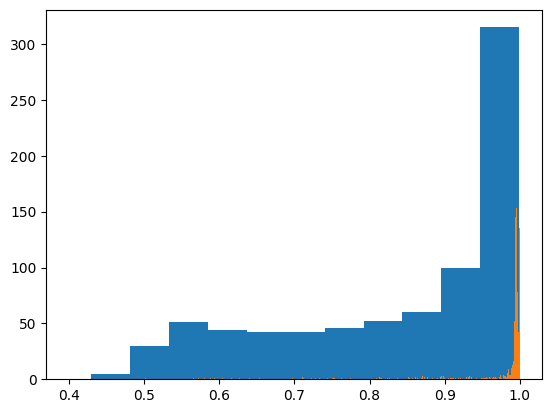

In [62]:
import matplotlib.pyplot as plt

plt.hist(histogram_data, bins='auto')
plt.hist(original_hist_data, bins='auto')
# plt.xlim(0.95, 1)

# Plot the max(logits) histogram

In [176]:
input_layer = model.input
output = model.layers[-2].output
logits_model = tf.keras.Model(input_layer, output)

outer_logits = logits_model.predict(outer_ds)
original_logits = logits_model.predict(original_ds)

6/6 [==============================] - 5s 633ms/step


(array([  2.,   8.,  14.,   5.,   9.,  17.,  55.,  81.,  88., 158.,  47.,
          7., 296.]),
 array([0.20823379, 0.26869813, 0.32916245, 0.3896268 , 0.45009112,
        0.51055545, 0.57101983, 0.63148415, 0.69194847, 0.7524128 ,
        0.81287712, 0.8733415 , 0.93380582, 0.99427015]),
 <BarContainer object of 13 artists>)

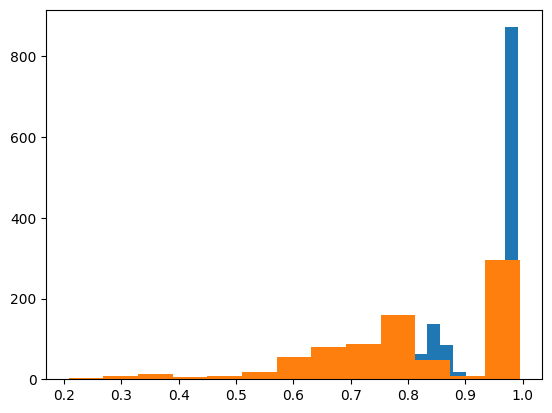

In [178]:
outer_hist_data = np.apply_along_axis(get_max_softmax, 1, outer_logits)
idd_hist_data = np.apply_along_axis(get_max_softmax, 1, original_logits)

plt.hist(idd_hist_data, bins='auto')
plt.hist(outer_hist_data, bins='auto')

# Out of distribution techniques

In [173]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve


def auroc(predictions, labels) -> tuple:
    fpr, tpr, thresholds = roc_curve(labels, predictions, pos_label=1)
    return thresholds, auc(fpr, tpr)

def aupr(predictions, labels) -> tuple:
    precision, recall, thresholds = precision_recall_curve(labels, predictions, pos_label=1)
    return thresholds, auc(recall, precision)

def fpr_at_95_tpr(predictions, labels):
    fpr, tpr, _ = roc_curve(labels, predictions, pos_label=1)

    if all(tpr < 0.95):
        # No threshold allows TPR >= 0.95
        return 0
    elif all(tpr >= 0.95):
        # All thresholds allow TPR >= 0.95, so find the lowest possible FPR
        idxs = [i for i, x in enumerate(tpr) if x >= 0.95]
        return min(map(lambda idx: fpr[idx], idxs))
    else:
        # Linear interp between values to get FPR at TPR == 0.95
        return np.interp(0.95, tpr, fpr)

def detection_error(predictions, labels):
    fpr, tpr, _ = roc_curve(labels, predictions, pos_label=1)

    # Get ratios of positives to negatives
    pos_ratio = sum(np.array(labels) == 1) / len(labels)
    neg_ratio = 1 - pos_ratio

    # Get indexes of all TPR >= 95%
    idxs = [i for i, x in enumerate(tpr) if x >= 0.95]

    # Calc error for a given threshold (i.e. idx)
    # Calc is the (# of negatives * FNR) + (# of positives * FPR)
    _detection_error = lambda idx: neg_ratio * (1 - tpr[idx]) + pos_ratio * fpr[idx]

    # Return the minimum detection error such that TPR >= 0.95
    return min(map(_detection_error, idxs))


In [165]:
labels = np.empty((0, 2))
for x, y in outer_ds:
    labels = np.append(labels, y.numpy(), axis=0)

predictions = result[:, 1]
labels = labels[:, 1]

## ROC

In [172]:
thresholds, auc = auroc(predictions, labels)
auc, thresholds


(0.9210742573617768,
 array([1.99906754e+00, 9.99067605e-01, 9.98491287e-01, 9.97734249e-01,
        9.97441292e-01, 9.97017741e-01, 9.96294677e-01, 9.96221602e-01,
        9.96179700e-01, 9.95837808e-01, 9.95775402e-01, 9.95560169e-01,
        9.94917035e-01, 9.94834185e-01, 9.94284689e-01, 9.94202077e-01,
        9.93794918e-01, 9.93573844e-01, 9.93464231e-01, 9.92965341e-01,
        9.92810011e-01, 9.92554486e-01, 9.91216660e-01, 9.90701556e-01,
        9.90615726e-01, 9.90522802e-01, 9.90420818e-01, 9.90093172e-01,
        9.90083575e-01, 9.89137053e-01, 9.88832712e-01, 9.88775373e-01,
        9.88318264e-01, 9.87839222e-01, 9.87545073e-01, 9.87322986e-01,
        9.86592472e-01, 9.86519933e-01, 9.86478746e-01, 9.85805809e-01,
        9.85704303e-01, 9.85616982e-01, 9.84522223e-01, 9.84409332e-01,
        9.84179974e-01, 9.83775318e-01, 9.83635545e-01, 9.83435094e-01,
        9.82963204e-01, 9.79107916e-01, 9.78536725e-01, 9.78304386e-01,
        9.78281915e-01, 9.78071690e-01, 9.7

## AuPR
Area under the Precision & Recall curve

In [174]:
thresholds, aupr = aupr(predictions, labels)
aupr, thresholds

(0.9170110471826799,
 array([5.43514499e-04, 9.51515161e-04, 1.18455384e-03, 1.27070211e-03,
        1.33444997e-03, 1.89796579e-03, 1.91215356e-03, 2.66517513e-03,
        3.27134505e-03, 3.28099448e-03, 3.44433193e-03, 3.44533147e-03,
        3.46457725e-03, 3.48904752e-03, 3.55776004e-03, 3.64217139e-03,
        3.66404909e-03, 3.75744677e-03, 3.87182389e-03, 3.92801361e-03,
        3.94492876e-03, 4.01320960e-03, 4.06510895e-03, 4.10914281e-03,
        4.16743290e-03, 4.19946294e-03, 4.35304642e-03, 4.39821091e-03,
        4.46354039e-03, 4.55516856e-03, 4.57472866e-03, 4.76824027e-03,
        4.78259102e-03, 4.80405986e-03, 4.82602743e-03, 4.86799283e-03,
        4.90219845e-03, 5.02629019e-03, 5.22653246e-03, 5.24321198e-03,
        5.36827231e-03, 5.41559048e-03, 5.43213682e-03, 5.45121031e-03,
        5.97745506e-03, 6.08800305e-03, 6.31524576e-03, 6.47175871e-03,
        6.84297318e-03, 6.89560082e-03, 7.01706763e-03, 7.20757758e-03,
        7.28121912e-03, 7.36477319e-03, 7.3

## FPR at 95% TPR
Return the False Positive Ratio when True Positive Ratio is at least 95%

In [152]:
fpr_tpr_95 = fpr_at_95_tpr(predictions, labels)
fpr_tpr_95

0.9579741379310345

## Detection error
Returns missclasification probability when TPR is 95%

In [146]:
error = detection_error(predictions, labels)
error

0.35465924895688455